# Deep Reinforcement Learning for Solving MCLP

## Prepare: Install dependencies
### Install with pip
* PyTorch>=1.1
* numpy
* tqdm
* cv2
* tensorboard_logger

In [1]:
from utils import torch_load_cpu, load_problem, get_inner_model, move_to
from nets.attention_model import AttentionModel
from train import train_epoch, validate
from tensorboard_logger import Logger as TbLogger
from torch.utils.data import DataLoader
import numpy as np

## load the settings

In [2]:
# load the run args
%run options

# Set the random seed
torch.manual_seed(1234)

# Optionally configure tensorboard
tb_logger = None
if not opts.no_tensorboard:
    tb_logger = TbLogger(os.path.join(opts.log_dir, "{}_{}".format(opts.problem, opts.n_users, opts.n_facilities), opts.run_name))

# Set the device
use_cuda=True
opts.device = torch.device("cuda" if use_cuda else "cpu")

## Figure out what's the problem

In [3]:
problem = load_problem(opts.problem)
problem

problems.MCLP.problem_MCLP.MCLP

## Initialize our policy network

In [4]:
model_class = {
    'attention': AttentionModel
}.get(opts.model, None)

model = model_class(
    embedding_dim=128,
    hidden_dim=128,
    problem=problem,
    n_encode_layers=3,
    mask_inner=True,
    mask_logits=True,
    normalization="batch",
    tanh_clipping=6,
    checkpoint_encoder=opts.checkpoint_encoder,
    shrink_size=opts.shrink_size,
    dy=False
).to(opts.device)

if opts.use_cuda and torch.cuda.device_count() > 1:
    model = torch.nn.DataParallel(model)

model

AttentionModel(
  (init_embed): Linear(in_features=2, out_features=128, bias=True)
  (init_dynamic): Linear(in_features=1, out_features=32, bias=True)
  (l2_dynamic): Linear(in_features=32, out_features=64, bias=True)
  (l3_dynamic): Linear(in_features=64, out_features=128, bias=True)
  (embedder): GraphAttentionEncoder(
    (layers): Sequential(
      (0): MultiHeadAttentionLayer(
        (0): SkipConnection(
          (module): MultiHeadAttention()
        )
        (1): Normalization(
          (normalizer): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (2): SkipConnection(
          (module): Sequential(
            (0): Linear(in_features=128, out_features=512, bias=True)
            (1): ReLU()
            (2): Linear(in_features=512, out_features=128, bias=True)
          )
        )
        (3): Normalization(
          (normalizer): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
  

## load the trained model

In [5]:
opts.load_path = "./outputs/MCLP/1000_100_20_20241006T130107/epoch-199.pt"

# opts.load_path = './outputs/MCLP_200_100_25/epoch-199.pt'
# load model from load_path
assert opts.load_path is None or opts.resume is None, "Only one of load path and resume can be given"
load_path = opts.load_path if opts.load_path is not None else opts.resume
if load_path is not None:
    print('  [*] Loading the trained model from {}'.format(load_path))
    load_data = torch_load_cpu(load_path)

# Overwrite model parameters by parameters to load q
model_ = get_inner_model(model)
model.load_state_dict({**model_.state_dict(), **load_data.get('model', {})})

  [*] Loading the trained model from ./outputs/MCLP/1000_100_20_20241006T130107/epoch-199.pt


<All keys matched successfully>

## Load the datasets

In [7]:
# filename = "./data/MCLP/MCLP_50_20_8.pkl"
filename = "./data/mclp_1000_100_20_random_train.pkl"
# filename = "./data/MCLP/MCLP_200_100_25.pkl"

In [8]:
dataset = problem.make_dataset(n_users=opts.n_users,
                               n_facilities=opts.n_facilities,
                               num_samples=opts.val_size,
                               filename = filename)

In [9]:
%%time
validate(model, dataset, opts)

Validating...


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.78it/s]

Validation overall avg_cost: -479.5921936035156 +- 0.12095291167497635
CPU times: total: 203 ms
Wall time: 729 ms


tensor(-479.5922)

In [10]:
opts.eval_batch_size = 1
opts.max_calc_batch_size = 1280000
width = 1280

In [11]:
from tqdm import tqdm
opts.decode_strategy = 'sampling'
model.eval()
model.set_decode_type(
    "greedy" if opts.decode_strategy in ('bs', 'greedy') else "sampling")
dataloader = DataLoader(dataset, batch_size=opts.eval_batch_size)


In [12]:
def get_best(sequences, cost, ids=None, batch_size=None):
    """
    Ids contains [0, 0, 0, 1, 1, 2, ..., n, n, n] if 3 solutions found for 0th instance, 2 for 1st, etc
    :param sequences:
    :param lengths:
    :param ids:
    :return: list with n sequences and list with n lengths of solutions
    """
    if ids is None:
        idx = cost.argmin()
        return sequences[idx:idx+1, ...], cost[idx:idx+1, ...]

    splits = np.hstack([0, np.where(ids[:-1] != ids[1:])[0] + 1])
    mincosts = np.minimum.reduceat(cost, splits)

    group_lengths = np.diff(np.hstack([splits, len(ids)]))
    all_argmin = np.flatnonzero(np.repeat(mincosts, group_lengths) == cost)
    result = np.full(len(group_lengths) if batch_size is None else batch_size, -1, dtype=int)

    result[ids[all_argmin[::-1]]] = all_argmin[::-1]

    return [sequences[i] if i >= 0 else None for i in result], [cost[i] if i >= 0 else math.inf for i in result]

In [13]:
results = []
for batch in tqdm(dataloader, disable=True):
    batch = move_to(batch, opts.device)
    start = time.time()
    with torch.no_grad():
        if opts.decode_strategy in ('sampling', 'greedy'):
            if opts.decode_strategy == 'greedy':
                assert width == 0, "Do not set width when using greedy"
                assert opts.eval_batch_size <= opts.max_calc_batch_size, \
                    "eval_batch_size should be smaller than calc batch size"
                batch_rep = 1
                iter_rep = 1
            elif width * opts.eval_batch_size > opts.max_calc_batch_size:
                assert opts.eval_batch_size == 1
                assert width % opts.max_calc_batch_size == 0
                batch_rep = opts.max_calc_batch_size
                iter_rep = width // opts.max_calc_batch_size
            else:
                batch_rep = width
                iter_rep = 1
            assert batch_rep > 0
            # This returns (batch_size, iter_rep shape)

            sequences, costs = model.sample_many(batch, batch_rep=batch_rep, iter_rep=iter_rep)
            batch_size = len(costs)
            ids = torch.arange(batch_size, dtype=torch.int64, device=costs.device)
#         else:
#             # assert opts.decode_strategy == 'bs'

#             cum_log_p, sequences, costs, ids, batch_size = model.beam_search(
#                 batch, beam_size=width,
#                 compress_mask=opts.compress_mask,
#                 max_calc_batch_size=opts.max_calc_batch_size
#             )
            if sequences is None:
                sequences = [None] * batch_size
                costs = [math.inf] * batch_size
            else:
                sequences, costs = get_best(
                    sequences.cpu().numpy(), costs.cpu().numpy(),
                    ids.cpu().numpy() if ids is not None else None,
                    batch_size
                )
            duration = time.time() - start
            for seq, cost in zip(sequences, costs):
                seq = seq.tolist()
                results.append((cost, seq, duration))
costs, tours, durations = zip(*results)

In [14]:
from datetime import timedelta
parallelism = opts.eval_batch_size
print("Average cost: {} +- {}".format(np.mean(costs), 2 * np.std(costs) / np.sqrt(len(costs))))
print("Average serial duration: {} +- {}".format(
    np.mean(durations), 2 * np.std(durations) / np.sqrt(len(durations))))
print("Average parallel duration: {}".format(np.mean(durations) / parallelism))
print("Calculated total duration: {}".format(timedelta(seconds=int(np.sum(durations) / parallelism))))

Average cost: -484.3651428222656 +- 0.18389550944614727
Average serial duration: 0.2793963587284088 +- 0.0012093587488511087
Average parallel duration: 0.02793963587284088
Calculated total duration: 0:00:55


## Load the real-world datasets

In [15]:
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

### LandScan Population Distribution
LandScan data is preprocessed and excluded the regions with no night-time population. Each point in this dataset represents the population aggregated to the centroid of the corresponding grid cell.

In [16]:
%%time
ls = gpd.read_file("./data/real/seattle_spatial_units_wspeed.shp")
ls['POINT_X'] = ls.geometry.x
ls['POINT_Y'] = ls.geometry.y
ls.head(3)

Wall time: 78.1 ms


,pop_val,speed_mean,pct_from_f,speed_free,geometry,POINT_X,POINT_Y
0,59,25,-10,28,POINT (-13621331.192 6063294.765),-1.362133e+07,6.063295e+06
1,708,25,-25,33,POINT (-13620403.530 6063294.765),-1.362040e+07,6.063295e+06
2,1781,25,-33,37,POINT (-13619475.867 6063294.765),-1.361948e+07,6.063295e+06


In [17]:
def normalize_to_1_10(data):
    """
    将一组数据归一化到1-10
    """
    min_val = min(data)
    max_val = max(data)
    normalized_data = [(x - min_val) / (max_val - min_val) * 9 + 1 for x in data]
    return normalized_data
# times -1 for maximizing the sum
ls['speed_pct_freeflow_rev'] = ls.pct_from_f * (-1)
ls['speed_pct_freeflow_rev_norm'] = normalize_to_1_10(ls['speed_pct_freeflow_rev'])

total_pop = sum(ls['speed_pct_freeflow_rev'])
total_pop_norm = sum(ls['speed_pct_freeflow_rev_norm'])
print("The number of records is ", len(ls))
print("The total speed unit are ", total_pop)
print("The total norm speed unit are ", total_pop_norm)

The number of records is  428
The total speed unit are  8676
The total norm speed unit are  1392.173913043476


### Candidate Billboard Location
Billboards data were retrieved from LAMAR

In [18]:
sitedf = pd.read_csv("./data/real/billboards_seattle.csv")
# sites = np.array(sitedf[['NORM_X', 'NORM_Y']], dtype=np.float64)
print("The number of billboards in Seattle area is ", len(sitedf))
sitedf.head(3)

The number of billboards in Seattle area is  417


,OBJECTID,FID,id,lat,long,cbsaName,cbsaGUID,plantId,tabID,panelID,panelNumbe,hoverText,heading,weeklyImpr,productTyp,POINT_X,POINT_Y
0,1,129578,716613,47.633163,-122.343788,"Seattle-Tacoma-Bellevue, WA",8430156E-10EE-DD11-BFE8-001EC9ACE3EE,1002017391,130178,1075967,13004,AURORA AV N WL 95F S/O GARFIELD ST SF-1,S,235621,BULLETINS,-13619248.18,6046041.771
1,2,129108,716297,47.687099,-122.311958,"Seattle-Tacoma-Bellevue, WA",8430156E-10EE-DD11-BFE8-001EC9ACE3EE,1002017391,129796,1075408,8021,15TH AV NE EL 142F N/O NE 80TH ST SF-2,S,70782,POSTERS,-13615704.88,6054956.230
2,3,128903,716162,47.553207,-122.278850,"Seattle-Tacoma-Bellevue, WA",8430156E-10EE-DD11-BFE8-001EC9ACE3EE,1002017391,129690,1075156,6370,RAINIER AV S EL 78F S/O BRANDON ST SF-1,S,66457,POSTERS,-13612019.32,6032843.680


## Normalization

In [19]:
def Normalization(x, y):
    max_x, max_y = np.max(x), np.max(y)
    min_x, min_y = np.min(x), np.min(y)
    S_x = (max_x-min_x)
    S_y = (max_y-min_y)
    S = max(S_x, S_y)
    new_x, new_y = (x-min_x)/S, (y-min_y)/S
    data_xy = np.vstack((new_x, new_y))
    Data = data_xy.T
    return new_x, new_y, S

In [20]:
ls_X = np.array(ls['POINT_X'])
ls_Y = np.array(ls['POINT_Y'])
bbs_X = np.array(sitedf['POINT_X'])
bbs_Y = np.array(sitedf['POINT_Y'])
X = np.concatenate([ls_X, bbs_X])
Y = np.concatenate([ls_Y, bbs_Y])
NORM_X, NORM_Y, S = Normalization(X, Y)
ls['NORM_X'] = NORM_X[:len(ls)]
ls['NORM_Y'] = NORM_Y[:len(ls)]
sitedf['NORM_X'] = NORM_X[len(ls):]
sitedf['NORM_Y'] = NORM_Y[len(ls):]

### Visualization of the input data

In [21]:
def render_scale_bar(ax, x, y, segments=2, height=0.01, seg_length=2000, unit='m', linewidth=1.):
    unit_scale_factor = {
        'm': 1,
        'km': 1000,
        'meters': 1,
        'kilometers': 1000,
        'miles': 1609.34,
        'mi': 1609.34,
        'ft': 0.3,
        }
    x_lim = ax.get_xlim()
    y_lim = ax.get_ylim()

    # how much percent does one unit takes on the x axis
    x_per_unit = 1. / (x_lim[1] - x_lim[0])
    y_per_unit = 1. / (y_lim[1] - y_lim[0])

    # base for ticks (0, 1)
    x_base = [x + seg_length * unit_scale_factor[unit] * x_per_unit * i for i in range(0, segments + 1)]
    ax.axhline(y_lim[0] + y / y_per_unit, x_base[0], x_base[-1], c='black')
    y_base = [y, y + height]
    for i in range(segments + 1):
        ax.axvline(x_lim[0] + x_base[i] / x_per_unit, y, y + height, c='black')
        xy = (x_lim[0] + x_base[i] / x_per_unit, y_lim[0] + (y - 0.015) / y_per_unit)  # data_coords
        ax.text(xy[0], xy[1], s='{}'.format(int(seg_length * i)), horizontalalignment='center', verticalalignment='center')
    ax.text(x_lim[0] + (x_base[-1] + 0.02) / x_per_unit, y_lim[0] + (y - 0.015) / y_per_unit,
            s=unit, horizontalalignment='left',
            verticalalignment='center')

In [22]:
def render_north_arrow(ax, x, y, size, ratio = 1):
    path = [(0, 1), (-ratio, -1), (0, -0.5), (ratio, -1), (0, 1)]
    path = [(i[0] * size + x, i[1] * size + y) for i in path]
    arrow = plt.Polygon(path, color='black', transform=ax.transAxes)
    ax.add_patch(arrow)
    ax.text(x, y-size*2, s = 'N', horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)

In [23]:
sitedf1 = sitedf[sitedf['POINT_X'] < max(ls['POINT_X'])]
sitedf1 = sitedf1[sitedf1['POINT_X'] > min(ls['POINT_X'])]
sitedf1 = sitedf1[sitedf1['POINT_Y'] < max(ls['POINT_Y'])]
sitedf1 = sitedf1[sitedf1['POINT_Y'] > min(ls['POINT_Y'])]

Wall time: 93.8 ms


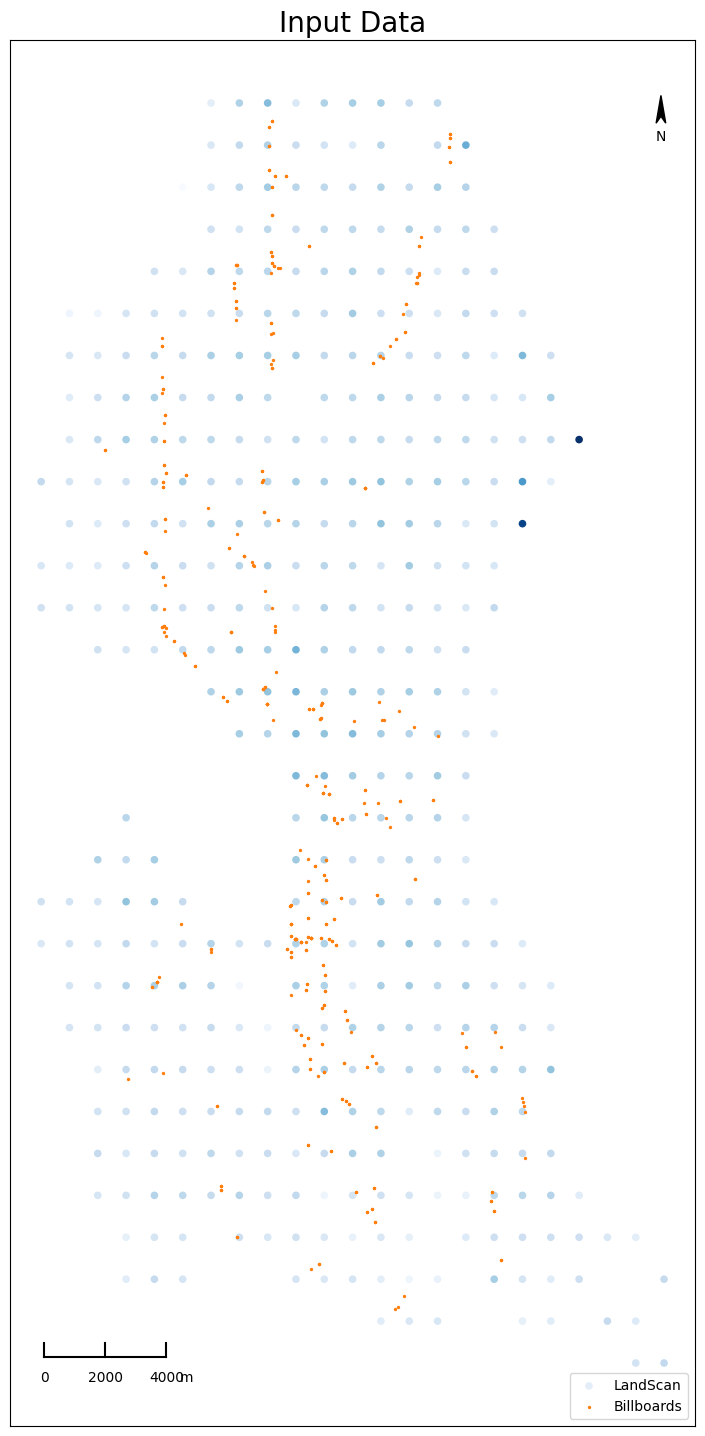

In [24]:
%%time
fig, ax = plt.subplots(figsize=(20,18))

ls.plot(ax = ax, column=ls['speed_pct_freeflow_rev'], k=5, markersize=20, cmap='Blues', label = 'LandScan')
ax.scatter(sitedf1['POINT_X'], sitedf1['POINT_Y'], c='C1', s=2, label = 'Billboards')

ax.axis('scaled')
ax.tick_params(axis='both', left=False, top=False, right=False,
               bottom=False, labelleft=False, labeltop=False,
               labelright=False, labelbottom=False)

ax.set_title("Input Data", fontsize=20)
render_scale_bar(ax = ax, x=0.05, y=0.05)
render_north_arrow(ax = ax, x = 0.95, y = 0.95, size = 0.01, ratio = 0.7)
ax.legend(loc='lower right', markerscale = 1)

In [25]:
def generate_candidate_sites(sites, M=100, heuristic=None):
    '''
    Generate M candidate sites with the convex hull of a point set
    Input:
        sites: a Pandas DataFrame with X, Y and other characteristic
        M: the number of candidate sites to generate
        heuristic:
    Return:
        sites: a Numpy array with shape of (M,2)
    '''
    if M is not None:
        if M > len(sites):
            M = None
    if heuristic is None or heuristic == '':
        if M is None:
            return sites
        index = np.random.choice(len(sites), M)
        return sites.iloc[index]
    elif heuristic == 'coverage':
        sites = sites.sort_values(by='pop_covered_2km', ascending=False).reset_index()
        if M is None:
            return sites
        return sites.iloc[:M]
    elif heuristic == 'coverage_e':
        sites = sites.sort_values(by='pop_covered_2km_exclusive', ascending=False).reset_index()
        if M is None:
            return sites
        return sites.iloc[:M]
    elif heuristic == 'impression':
        sites = sites.sort_values(by='weeklyImpr', ascending=False).reset_index()
        if M is None:
            return sites
        return sites.iloc[:M]
    elif heuristic == 'impression_e':
        sites = sites.sort_values(by='weeklyImpr_2km_exclusive', ascending=False).reset_index()
        if M is None:
            return sites
        return sites.iloc[:M]

In [26]:
bbs_ = generate_candidate_sites(sitedf, M=None, heuristic="")

Wall time: 78.1 ms


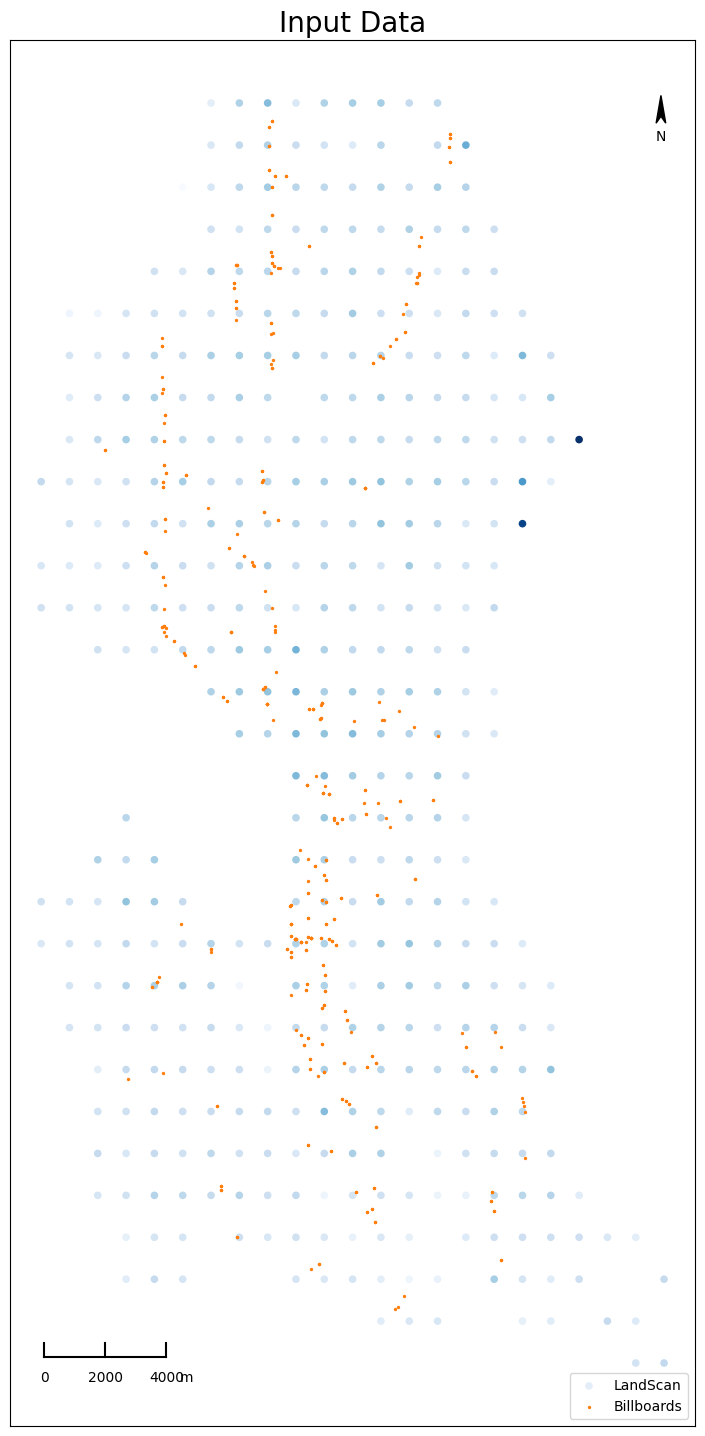

In [27]:
%%time
fig, ax = plt.subplots(figsize=(20,18))
# ax.scatter(ls['POINT_X'],ls['POINT_Y'], color='Blue', s=ls['speed_pct_freeflow_rev'])
ls.plot(ax = ax, column=ls['speed_pct_freeflow_rev'], k=5, markersize=20, cmap='Blues', label = 'LandScan')
ax.scatter(bbs_['POINT_X'], bbs_['POINT_Y'], c='C1', s=2, label = 'Billboards')

ax.axis('scaled')
ax.tick_params(axis='both', left=False, top=False, right=False,
               bottom=False, labelleft=False, labeltop=False,
               labelright=False, labelbottom=False)

ax.set_title("Input Data", fontsize=20)
render_scale_bar(ax = ax, x=0.05, y=0.05)
render_north_arrow(ax = ax, x = 0.95, y = 0.95, size = 0.01, ratio = 0.7)
ax.legend(loc='lower right', markerscale = 1)

In [99]:
def gen_real_data(ls, num_sample):
    real_datasets = []
    for i in range(num_sample):
        bbs_ = generate_candidate_sites(sitedf, M=50, heuristic="")
        real_data = {}
        real_data["users"] = torch.tensor(np.array(ls[['NORM_X', 'NORM_Y']])).to(torch.float32)
        real_data["facilities"] = torch.tensor(np.array(bbs_[['NORM_X', 'NORM_Y']])).to(torch.float32)
        real_data['demand'] = torch.tensor(np.array(ls['speed_pct_freeflow_rev_norm'])).to(torch.float32)
        real_data["p"] = 15
        real_data["r"] = 2000/S
        real_datasets.append(real_data)
    return bbs_, real_datasets

In [100]:
num_sample = 100
opts.eval_batch_size = 50
opts.max_calc_batch_size = 1280000
width = 128
bbs_, real_datasets = gen_real_data(ls, num_sample)

In [101]:
from torch.utils.data import DataLoader
from tqdm import tqdm
opts.decode_strategy = 'sampling'
model.eval()
model.set_decode_type(
    "greedy" if opts.decode_strategy in ('bs', 'greedy') else "sampling")
dataloader = DataLoader(real_datasets, batch_size=opts.eval_batch_size)


In [102]:
def get_best(sequences, cost, ids=None, batch_size=None):
    """
    Ids contains [0, 0, 0, 1, 1, 2, ..., n, n, n] if 3 solutions found for 0th instance, 2 for 1st, etc
    :param sequences:
    :param lengths:
    :param ids:
    :return: list with n sequences and list with n lengths of solutions
    """
    if ids is None:
        idx = cost.argmin()
        return sequences[idx:idx+1, ...], cost[idx:idx+1, ...]

    splits = np.hstack([0, np.where(ids[:-1] != ids[1:])[0] + 1])
    mincosts = np.minimum.reduceat(cost, splits)

    group_lengths = np.diff(np.hstack([splits, len(ids)]))
    all_argmin = np.flatnonzero(np.repeat(mincosts, group_lengths) == cost)
    result = np.full(len(group_lengths) if batch_size is None else batch_size, -1, dtype=int)

    result[ids[all_argmin[::-1]]] = all_argmin[::-1]

    return [sequences[i] if i >= 0 else None for i in result], [cost[i] if i >= 0 else math.inf for i in result]

In [103]:
results = []
for batch in tqdm(dataloader, disable=True):
    batch = move_to(batch, opts.device)
    start = time.time()
    with torch.no_grad():
        if opts.decode_strategy in ('sampling', 'greedy'):
            if opts.decode_strategy == 'greedy':
                assert width == 0, "Do not set width when using greedy"
                assert opts.eval_batch_size <= opts.max_calc_batch_size, \
                    "eval_batch_size should be smaller than calc batch size"
                batch_rep = 1
                iter_rep = 1
            elif width * opts.eval_batch_size > opts.max_calc_batch_size:
                assert opts.eval_batch_size == 1
                assert width % opts.max_calc_batch_size == 0
                batch_rep = opts.max_calc_batch_size
                iter_rep = width // opts.max_calc_batch_size
            else:
                batch_rep = width
                iter_rep = 1
            assert batch_rep > 0
            # This returns (batch_size, iter_rep shape)

            sequences, costs = model.sample_many(batch, batch_rep=batch_rep, iter_rep=iter_rep)
            batch_size = len(costs)
            ids = torch.arange(batch_size, dtype=torch.int64, device=costs.device)
#         else:
#             # assert opts.decode_strategy == 'bs'

#             cum_log_p, sequences, costs, ids, batch_size = model.beam_search(
#                 batch, beam_size=width,
#                 compress_mask=opts.compress_mask,
#                 max_calc_batch_size=opts.max_calc_batch_size
#             )
            if sequences is None:
                sequences = [None] * batch_size
                costs = [math.inf] * batch_size
            else:
                sequences, costs = get_best(
                    sequences.cpu().numpy(), costs.cpu().numpy(),
                    ids.cpu().numpy() if ids is not None else None,
                    batch_size
                )
            duration = time.time() - start
            for seq, cost in zip(sequences, costs):
                seq = seq.tolist()
                results.append((cost, seq, duration))
costs, tours, durations = zip(*results)

In [104]:
from torch.utils.data import DataLoader

instance = next(iter(DataLoader(real_datasets, batch_size = 1)))
instance

{'users': tensor([[[0.1348, 1.0000],
          [0.1573, 1.0000],
          [0.1798, 1.0000],
          [0.2022, 1.0000],
          [0.2247, 1.0000],
          [0.2472, 1.0000],
          [0.2697, 1.0000],
          [0.2921, 1.0000],
          [0.3146, 1.0000],
          [0.1348, 0.9666],
          [0.1573, 0.9666],
          [0.1798, 0.9666],
          [0.2022, 0.9666],
          [0.2247, 0.9666],
          [0.2472, 0.9666],
          [0.2697, 0.9666],
          [0.3146, 0.9666],
          [0.3371, 0.9666],
          [0.1124, 0.9332],
          [0.1348, 0.9332],
          [0.1573, 0.9332],
          [0.1798, 0.9332],
          [0.2022, 0.9332],
          [0.2247, 0.9332],
          [0.2472, 0.9332],
          [0.2697, 0.9332],
          [0.2921, 0.9332],
          [0.3146, 0.9332],
          [0.3371, 0.9332],
          [0.1348, 0.8998],
          [0.1573, 0.8998],
          [0.1798, 0.8998],
          [0.2022, 0.8998],
          [0.2247, 0.8998],
          [0.2472, 0.8998],
          [

In [105]:
cost, _, solution = model(move_to(instance, opts.device), return_pi=True)
solution = np.array(solution.squeeze(-1).cpu())[0]
solution

array([49, 33, 30, 43, 34, 13, 45, 47,  3, 10, 20, 40,  6, 19, 41],
      dtype=int64)

In [106]:
cost

tensor([-393.3478], device='cuda:0')

In [107]:
def plot_result(ls, opt_sites, radius):
    '''
    Plot the result
    Input:
        points: input points, Numpy array in shape of [N,2]
        opt_sites: locations K optimal sites, Pandas DataFrame
        radius: the radius of circle
    '''
    fig, ax = plt.subplots(figsize=(20, 15))
    ls.plot(ax=ax, column=ls['speed_pct_freeflow_rev'], k=5, markersize=1, cmap='Blues', label='LandScan')
    legend_plot_flag = {'current': False, 'selected': False}

    for cnt, site in opt_sites.iterrows():
        if 'current' in opt_sites.columns and site['current'] == True:  #ncurrent
            if legend_plot_flag['current'] == False:
                ax.scatter(site['POINT_X'], site['POINT_Y'], c='red', marker='+', s=1, label='Current Billboards')
                circlelabel = 'Service Range for Current Billboards'
                legend_plot_flag['current'] = True
            ax.scatter(site['POINT_X'], site['POINT_Y'], c='red', marker='+', s=100)
            #             circle = plt.Circle(site[['POINT_X','POINT_Y']], radius, color='red', fill=False, lw=2, label = circlelabel)
            circle = plt.Circle(site[['POINT_X', 'POINT_Y']], radius, color='red', fill=False, lw=2)

            ax.add_artist(circle)
        else:
            if legend_plot_flag['selected'] == False:
                ax.scatter(site['POINT_X'], site['POINT_Y'], c='C1', marker='+', s=1,
                           label='Optimized Selected Billboards')
                circlelabel = 'Service Range for Optimized Selected Billboards'
                legend_plot_flag['selected'] = True
            ax.scatter(site['POINT_X'], site['POINT_Y'], c='C1', marker='+', s=100)
            #             circle = plt.Circle(site[['POINT_X','POINT_Y']], radius, color='C1', fill=False, lw=2, label = circlelabel)
            circle = plt.Circle(site[['POINT_X', 'POINT_Y']], radius, color='C1', fill=False, lw=2)
            ax.add_artist(circle)

    ax.axis('scaled')
    ax.tick_params(axis='both', left=False, top=False, right=False,
                   bottom=False, labelleft=False, labeltop=False,
                   labelright=False, labelbottom=False)
    title = 'Selected ' + str(len(opt_sites)) + ' Sites that Serve ' + str(radius) + ' m'
    ax.set_title(title, fontsize=20)
    render_scale_bar(ax=ax, x=0.05, y=0.05)
    render_north_arrow(ax=ax, x=0.95, y=0.95, size=0.01, ratio=0.7)
    ax.legend(loc='lower right', markerscale=10)
    return ax

<AxesSubplot:title={'center':'Selected 15 Sites that Serve 2000 m'}>

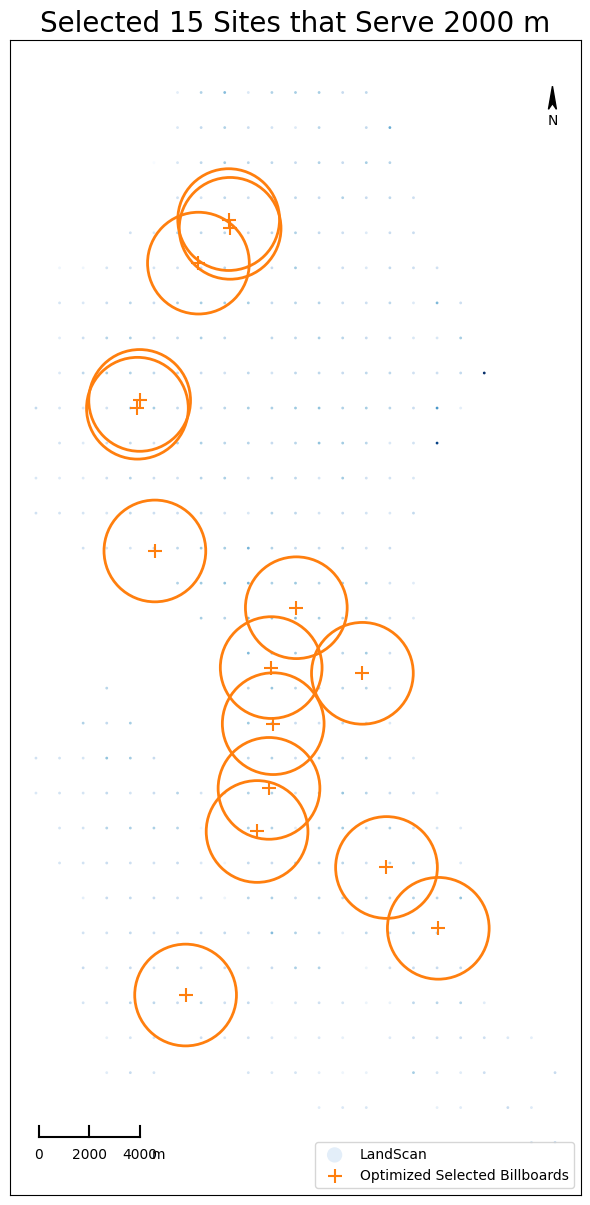

In [108]:
opt_sites = bbs_.iloc[solution]
plot_result(ls,opt_sites,2000)

In [104]:
from nets.reinforce_baselines import RolloutBaseline, WarmupBaseline
import torch.optim as optim

# Initialize baseline
baseline = RolloutBaseline(model, problem, opts)

if opts.bl_warmup_epochs > 0:
    baseline = WarmupBaseline(baseline, opts.bl_warmup_epochs, warmup_exp_beta=opts.exp_beta)

# Load baseline from data, make sure script is called with same type of baseline
if 'baseline' in load_data:
    baseline.load_state_dict(load_data['baseline'])

# Initialize optimizer
optimizer = optim.Adam(
    [{'params': model.parameters(), 'lr': opts.lr_model}]
    + (
        [{'params': baseline.get_learnable_parameters(), 'lr': opts.lr_critic}]
        if len(baseline.get_learnable_parameters()) > 0
        else []
    )
)
# Initialize learning rate scheduler, decay by lr_decay once per epoch!
lr_scheduler = optim.lr_scheduler.LambdaLR(optimizer, lambda epoch: opts.lr_decay ** epoch)
opts.n_epochs = 2
opts.epoch_start = 0
from nets.attention_model import set_decode_type
from train import train_batch

for epoch in range(opts.epoch_start, opts.epoch_start + opts.n_epochs):
    step = epoch * (opts.epoch_size // opts.batch_size)
    start_time = time.time()
    training_dataset = real_datasets
    training_dataloader = DataLoader(training_dataset, batch_size=100, num_workers=4)

    # Put model in train mode!
    model.train()
    set_decode_type(model, "sampling")
    for batch_id, batch in enumerate(tqdm(training_dataloader, disable=opts.no_progress_bar)):
        train_batch(
            model,
            optimizer,
            baseline,
            epoch,
            batch_id,
            step,
            batch,
            tb_logger,
            opts
        )

        step += 1

    epoch_duration = time.time() - start_time
    print("Finished epoch {}, took {} s".format(epoch, time.strftime('%H:%M:%S', time.gmtime(epoch_duration))))

    if (opts.checkpoint_epochs != 0 and epoch % opts.checkpoint_epochs == 0) or epoch == opts.n_epochs - 1:
        print('Saving model and state...')
        torch.save(
            {
                'model': get_inner_model(model).state_dict(),
                'optimizer': optimizer.state_dict(),
                'rng_state': torch.get_rng_state(),
                'cuda_rng_state': torch.cuda.get_rng_state_all(),
                'baseline': baseline.state_dict()
            },
            os.path.join(opts.save_dir, 'epoch-{}.pt'.format(epoch))
        )
    avg_cost = validate(model, real_datasets, opts)
    if not opts.no_tensorboard:
        tb_logger.log_value('val_avg_reward', avg_cost, step)

    baseline.epoch_callback(model, epoch)

    # lr_scheduler should be called at end of epoch
    lr_scheduler.step()